In [1]:
import tensorflow as tf
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
from Network.Network import unsupervised_HomographyNet
from Misc.MiscUtils import *
from Misc.DataUtils import *
import numpy as np
import time
import argparse
import shutil
import string
import math as m
from tqdm import tqdm
from Misc.TFSpatialTransformer import *


# Don't generate pyc codes
sys.dont_write_bytecode = True

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Num GPUs Available:  1


In [2]:
def getPatchIndices(corners_a):
    patch_indices = []
    for i in range(corners_a.shape[0]):
        xmin,ymin = corners_a[i,0,0], corners_a[i,0,1]
        xmax,ymax = corners_a[i,3,0], corners_a[i,3,1]
#         print(xmin,ymin,xmax,ymax)
        X, Y = np.mgrid[xmin:xmax, ymin:ymax]
        patch_indices.append(np.dstack((Y,X))) 
    return np.array(patch_indices)


def loadData(folder_name, files_in_dir, points_list,NumTestSamples):

    patch_pairs = []
    corners1 = []
    patches2 = []
    images1 = []


    for n in range(NumTestSamples):
#         index = random.randint(0, len(files_in_dir)-1)  #len(files_in_dir)-1
        index = n
        patch1_name = folder_name + os.sep + "PA/" + files_in_dir[index, 0]
        patch1 = cv2.imread(patch1_name, cv2.IMREAD_GRAYSCALE)

        patch2_name = folder_name + os.sep + "PB/" + files_in_dir[index, 0] 
        patch2 = cv2.imread(patch2_name, cv2.IMREAD_GRAYSCALE)

        image1_name = folder_name + os.sep + "IA/" + files_in_dir[index, 0]
        image1 = cv2.imread(image1_name, cv2.IMREAD_GRAYSCALE)

        if(patch1 is None) or (patch2 is None):
            print(patch1_name, " is empty. Ignoring ...")
            continue

        patch1 = np.float32(patch1)
        patch2 = np.float32(patch2) 
        image1 = np.float32(image1)   

        #combine images along depth
        patch_pair = np.dstack((patch1, patch2))     
        corner1 = points_list[index, :, :, 0]
        
        
        patch_pairs.append(patch_pair)
        corners1.append(corner1)
        patches2.append(patch2.reshape(128, 128, 1))

        images1.append(image1.reshape(image1.shape[0], image1.shape[1], 1))

    patch_indices = getPatchIndices(np.array(corners1))    
    return np.array(patch_pairs), np.array(corners1), np.array(patches2), np.array(images1), patch_indices

def TestOperation(PatchPairsPH, CornerPH, Patch2PH, Image1PH,patchIndicesPH, ModelPath, BasePath, files_in_dir, pointsList, SavePath, NumTestSamples):
    """
    Inputs: 
    ImgPH is the Input Image placeholder
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    DataPath - Paths of all images where testing will be run on
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to ./TxtFiles/PredOut.txt
    """
    # Create the graph
    # Predict output with forward pass, MiniBatchSize for Test is 1
    _, _, H_batches = unsupervised_HomographyNet(PatchPairsPH, CornerPH, Patch2PH, Image1PH,patchIndicesPH, NumTestSamples)

    # Setup Saver
    # load session and run
    Saver = tf.train.Saver()
    with tf.Session() as sess:
        Saver.restore(sess, ModelPath)
        print('Number of parameters in this model are %d ' % np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))
        
            
        PatchPairsBatch, Corner1Batch, patch2Batch, Image1Batch, patchIndicesBatch = loadData(BasePath, files_in_dir, pointsList, NumTestSamples)
        FeedDict = {PatchPairsPH: PatchPairsBatch, CornerPH: Corner1Batch, Patch2PH: patch2Batch, Image1PH: Image1Batch, patchIndicesPH: patchIndicesBatch}            
            
        H_pred = sess.run(H_batches, FeedDict)
        np.save(SavePath, H_pred)
        
#         OutSaveT.write(str(PredT)+'\n')    
#         OutSaveT.close()


In [4]:
BasePath = '/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_synthetic/'
CheckPointPath = '/home/gokul/CMSC733/hgokul_p1/Phase2/Checkpoints/unsupervised/'

files_in_dir, SaveCheckPoint, ImageSize, NumTestSamples, _ = SetupAll(BasePath, CheckPointPath)
LogsPath = '/home/gokul/CMSC733/hgokul_p1/Phase2/Logs/'

print(NumTestSamples)
pointsList = np.load(BasePath+'/pointsList.npy')

NumTestSamples = 500
CornerPH = tf.placeholder(tf.float32, shape=(NumTestSamples, 4,2))
PatchPairsPH = tf.placeholder(tf.float32, shape=(NumTestSamples, 128, 128 ,2))
Patch2PH = tf.placeholder(tf.float32, shape=(NumTestSamples, 128, 128, 1))
Images1PH = tf.placeholder(tf.float32, shape=(NumTestSamples, 240, 320, 1))
patchIndicesPH = tf.placeholder(tf.int32, shape=(NumTestSamples, 128, 128 ,2))

ModelPath = CheckPointPath + '99model.ckpt'
SavePath = "/home/gokul/CMSC733/hgokul_p1/Phase2/Results/unsupervised/H_preds_train.npy"


25000


In [5]:
TestOperation(PatchPairsPH, CornerPH, Patch2PH, Images1PH,patchIndicesPH, ModelPath, BasePath, files_in_dir, pointsList, SavePath, NumTestSamples)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layer

In [6]:
H_preds = np.load(SavePath)
H_preds.shape

(500, 3, 3)

In [7]:
path = '/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_synthetic/'
H4True = pd.read_csv(path+'H4.csv', index_col = False)
H4True = H4True.to_numpy()
H4True = H4True[:NumTestSamples]

X_test, Ia_batches, Ib_batches = [],[],[]
for i, p in enumerate(files_in_dir[:NumTestSamples]):

    tPatchA = cv2.imread(path+"PA/"+ str(p[0]), cv2.IMREAD_GRAYSCALE)
    tPatchB = cv2.imread(path+"PB/"+ str(p[0]), cv2.IMREAD_GRAYSCALE)
    tPatch = np.dstack((tPatchA, tPatchB))    
    
    Ia_batches.append(cv2.imread(path+"IA/"+ str(p[0])))
    Ib_batches.append(cv2.imread(path+"IB/"+ str(p[0])))
    
    X_test.append(tPatch)

pointsList = np.load(path+'/pointsList.npy')    
X_test = np.array(X_test)
Ib_batches = np.array(Ib_batches)
Ia_batches = np.array(Ia_batches)    

corners_a = pointsList[:NumTestSamples,:,:,0]
corners_b = pointsList[:NumTestSamples,:,:,1]


print(corners_a.shape,corners_b.shape)

(500, 4, 2) (500, 4, 2)


# Visualisation

In [8]:
def getCornersFromH4pt(corner1, H4pt):
    corners1 = np.array(corner1.copy())
    del_corners = H4pt.reshape(2,4).T
    corners2 = corners1 + del_corners
    return corners2

def drawCorners(image, corners, color):

    corners_ = np.array(corners.copy())
    r = corners_[2,:].copy()
    corners_[2,:] = corners_[3,:]
    corners_[3,:] = r
    corners_ = corners_.reshape(-1,1,2)
#     print(corners_)
    corners_ = corners_.astype(int)
    image_corners = cv2.polylines(image.copy(),[corners_],True,color, 4)
    return image_corners

def getHfromH4pt(corners1, H4pt):
#     print("H4pt is: ")
#     print(H4pt.reshape(2,4).T)

    del_corners = H4pt.reshape(2,4).T
    
    corners1 = np.array(corners1)
#     print("corner1 is: ")
#     print(corners1)

    corners2 = corners1 + del_corners
#     print("corner2 is: ")
#     print(corners2)

    H = cv2.getPerspectiveTransform(np.float32(corners1), np.float32(corners2))
#     print("H is:")
#     print(H)
    return H

def warpImage(img, corners, H):
    image = img.copy()
    h, w, _= image.shape

    corners_ = np.array(corners)
    corners_ = corners_.reshape((-1,1,2))

    image_transformed = cv2.warpPerspective(image, H, (w,h))
    corner_transformed = cv2.perspectiveTransform(np.float32(corners_), H)
    corner_transformed = corner_transformed.astype(int)
    
    return image_transformed, corner_transformed


In [9]:
i = 1
alp = 'a'
corners_a[i],corners_b[i]

(array([[ 53,  67],
        [ 53, 195],
        [181,  67],
        [181, 195]]),
 array([[ 22,  93],
        [ 53, 176],
        [175,  65],
        [157, 177]]))

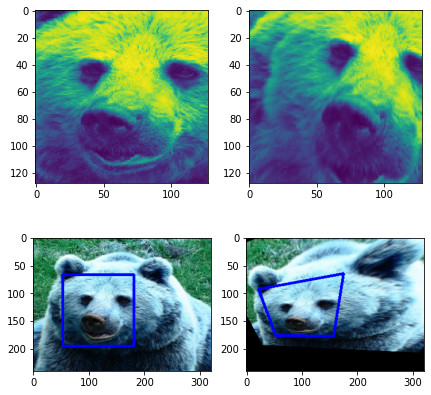

In [10]:
imA = Ia_batches[i]
H_AB = getHfromH4pt(corners_a[i], H4True[i])
imB, corners_bcal = warpImage(imA, corners_a[i], H_AB)

patchA,patchB = X_test[i,:,:,0], X_test[i,:,:,1]

imA_corners = drawCorners(imA, corners_a[i], (0,0,255))
imB_corners = drawCorners(imB, corners_bcal, (0,0,255))

fx, plts = plt.subplots(2,2,figsize = (7,7))
plts[0][0].imshow(patchA)
plts[0][1].imshow(patchB)
plts[1][0].imshow(imA_corners)
plts[1][1].imshow(imB_corners)

In [11]:
# 

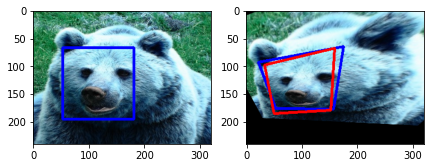

In [12]:
corners_ai = corners_a[i].reshape((-1,1,2))

corners_b_pred_i = cv2.perspectiveTransform(np.float32(corners_ai), H_preds[i])
corners_b_pred_i = corners_b_pred_i.astype(int)

imA_corners = drawCorners(imA, corners_a[i], (0,0,255))
imB_corners_pred = drawCorners(imB_corners, corners_b_pred_i, (255,0,0))

fx, plts = plt.subplots(1,2,figsize = (7,7))
plts[0].imshow(imA_corners)
plts[1].imshow(imB_corners_pred)